### Análisis mediante Ridge

In [1]:
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configurar MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("regresion_ridge")

<Experiment: artifact_location='mlflow-artifacts:/916738605820158483', creation_time=1748576287230, experiment_id='916738605820158483', last_update_time=1748576287230, lifecycle_stage='active', name='regresion_ridge', tags={}>

In [3]:
# Cargar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/dodobeatle/dataeng-datos/refs/heads/main/ToyotaCorolla.csv",
    encoding="utf8",
    engine="python"
)
pd.set_option('display.max_columns', None)

df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Automatic,cc,Doors,Cylinders,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,0,2000,3,4,5,210,1165,0,1,3,1,1,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,0,2000,3,4,5,210,1165,0,1,3,1,1,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,0,2000,3,4,5,210,1170,1,1,3,1,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0


In [4]:
# Calcular nueva edad y eliminar columnas redundantes
df["Age_08_04_calculado"] = (2004 - df["Mfg_Year"]) * 12 + (8 - df["Mfg_Month"])
df.drop(columns=["Mfg_Year", "Mfg_Month", "Age_08_04"], inplace=True)

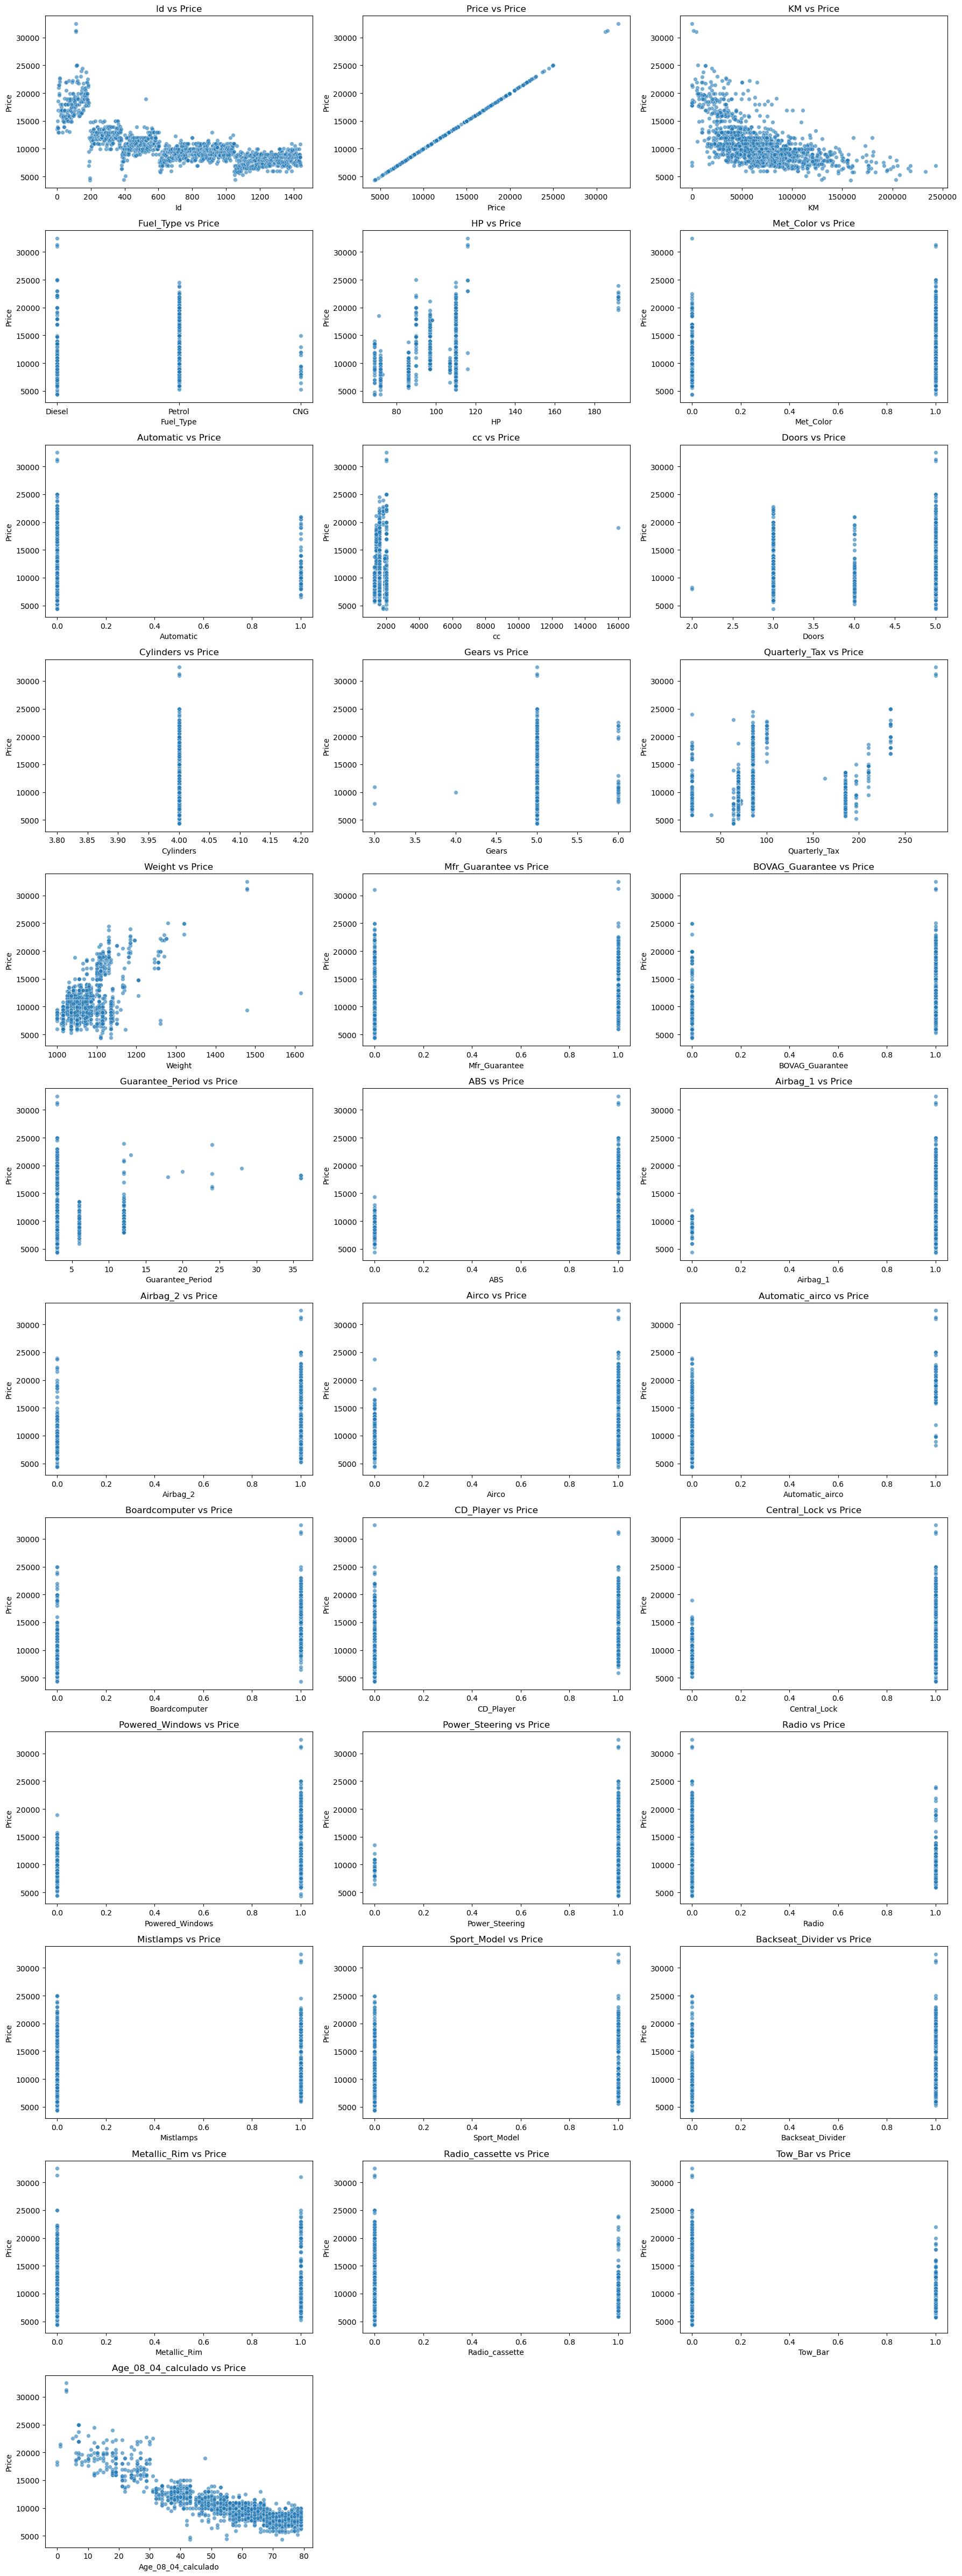

In [5]:
# Dataset limpio que contiene las features y el target "Price"
df_plot = df.copy()
df_plot = df_plot.drop(columns=["Model"])

# Creamos una figura con subplots
n_cols = 3
n_rows = int(len(df_plot.columns) / n_cols) + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Graficar scatter plot para cada feature contra el precio
for i, col in enumerate(df_plot.columns):
    sns.scatterplot(ax=axes[i], data=df_plot, x=col, y="Price", alpha=0.6, s=30)
    axes[i].set_title(f"{col} vs Price")

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [6]:
def remove_outliers_iqr(df, features, factor=1.5):
    df_clean = df.copy()
    for col in features:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

In [7]:
features_numericas = df_plot.select_dtypes(include='number').columns
df_clean = remove_outliers_iqr(df_plot, features_numericas, factor=5)

In [8]:
#import seaborn as sns
#import matplotlib.pyplot as plt

#for col in features_numericas:
#    plt.figure(figsize=(6,1.4))
#    sns.boxplot(data=df_plot, x=col)
#    plt.title(f"Boxplot: {col}")
#    plt.tight_layout()
 #   plt.show()

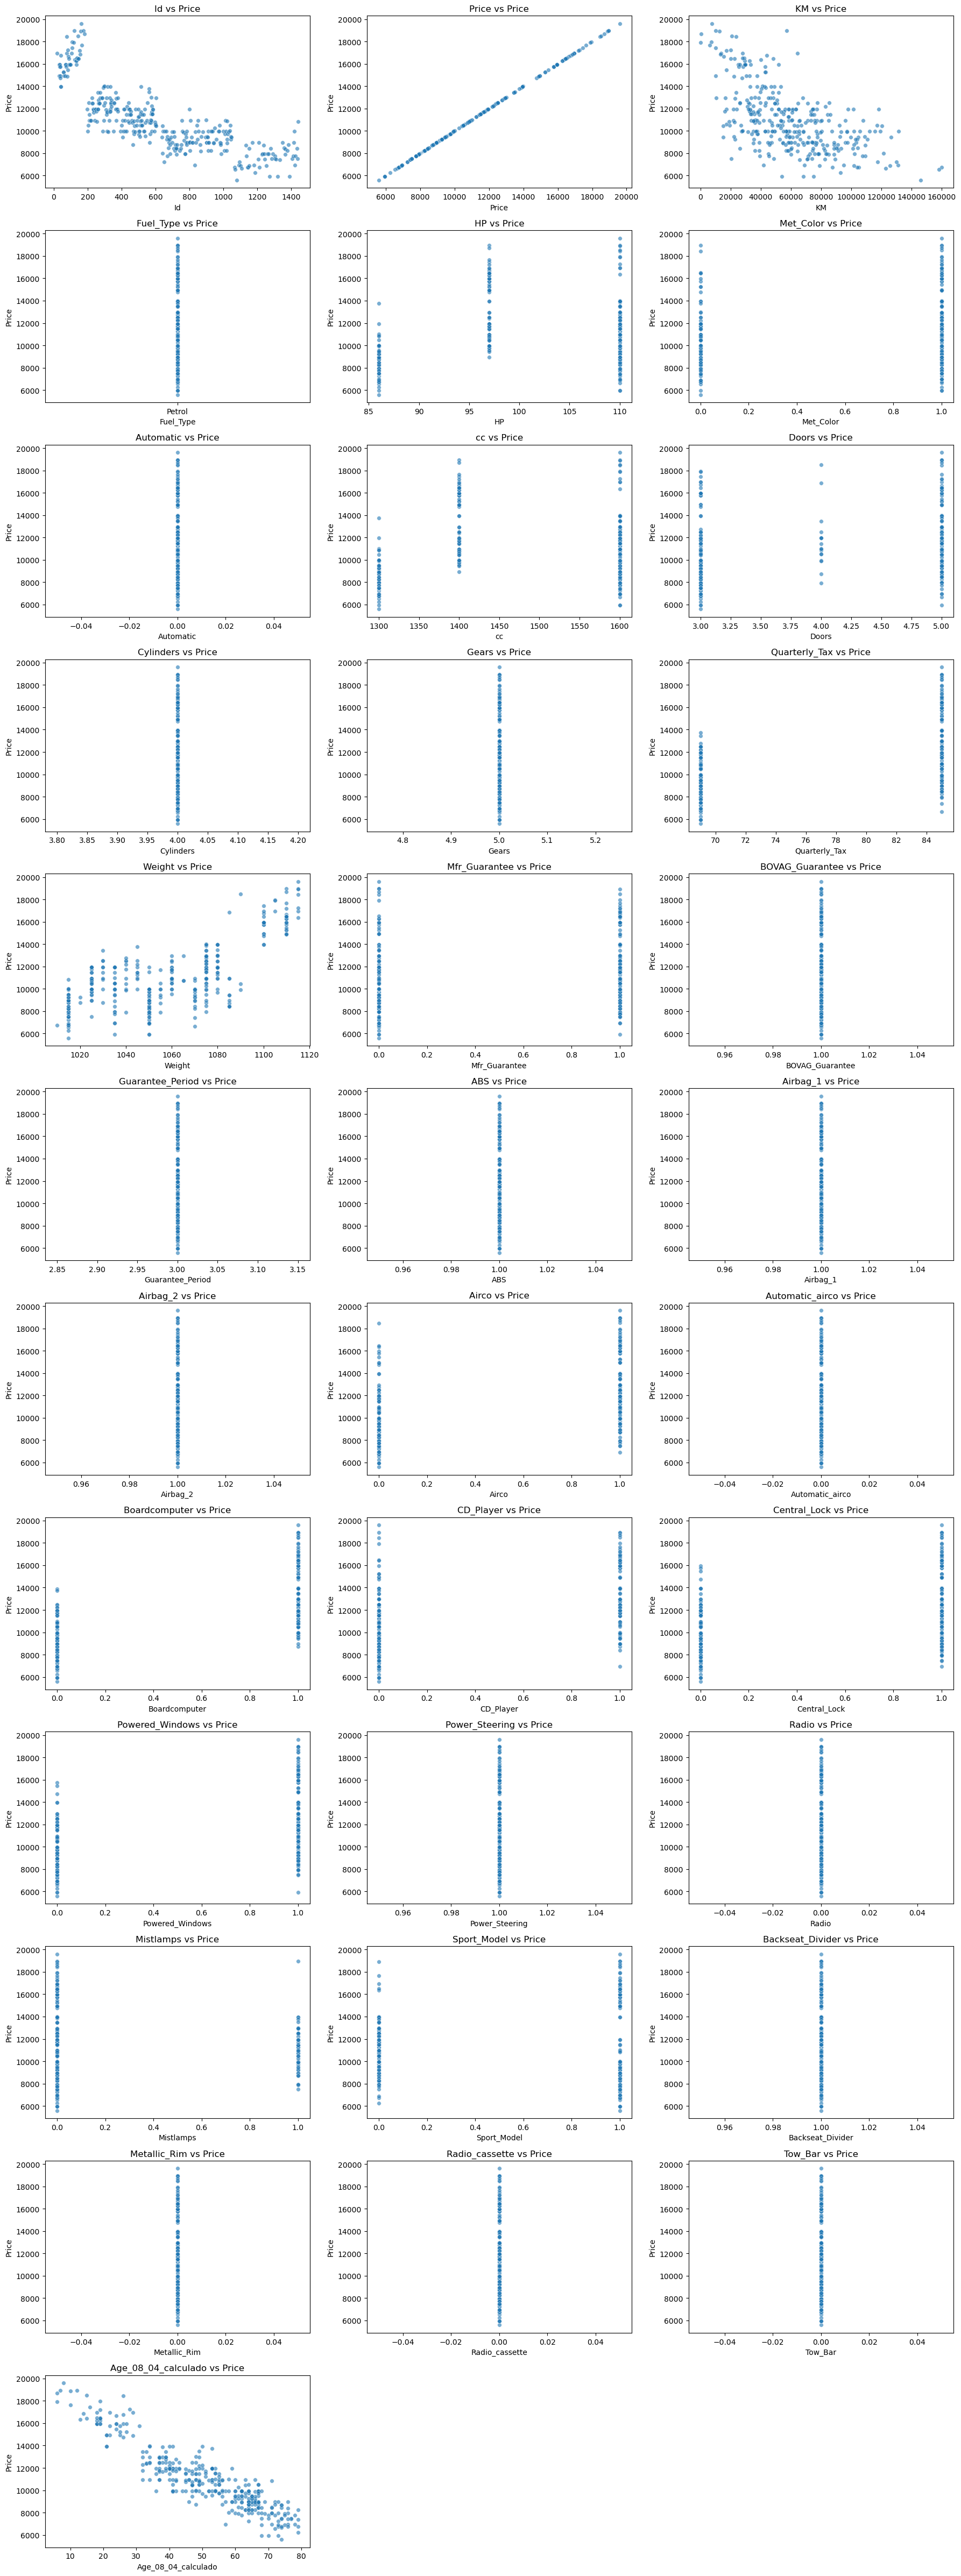

In [9]:
# Creamos una figura con subplots
n_cols = 3
n_rows = int(len(df_clean.columns) / n_cols) + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Graficar scatter plot para cada feature contra el precio
for i, col in enumerate(df_clean.columns):
    sns.scatterplot(ax=axes[i], data=df_clean, x=col, y="Price", alpha=0.6, s=30)
    axes[i].set_title(f"{col} vs Price")

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Copia del dataset
df_ridge = df_clean.copy()

# X e y
X = df_ridge.drop(columns="Price")
y = df_ridge["Price"]

# One-hot + conversión numérica
X = pd.get_dummies(X, drop_first=True)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# Alpha grid
alphas = np.logspace(-4, 4, 100)

# ==== MLflow Tracking ====
with mlflow.start_run(run_name="Ridge Regression CV"):

    # Modelo
    ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring="neg_mean_squared_error")
    ridge_cv.fit(X_train, y_train)

    # Predicciones
    y_train_pred = ridge_cv.predict(X_train)
    y_test_pred = ridge_cv.predict(X_test)

    # Métricas
    mse_train = mean_squared_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Coeficientes
    coeficientes = pd.Series(ridge_cv.coef_, index=X.columns)

    # Log de parámetros
    mlflow.log_param("alpha_optimo", ridge_cv.alpha_)
    mlflow.log_param("cv", 5)

    # Log de métricas
    mlflow.log_metric("mse_train", mse_train)
    mlflow.log_metric("r2_train", r2_train)
    mlflow.log_metric("mse_test", mse_test)
    mlflow.log_metric("r2_test", r2_test)

    # Log del modelo
    mlflow.sklearn.log_model(ridge_cv, "ridge_model")

    print("Experimento registrado en MLflow")

2025/05/30 22:21:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experimento registrado en MLflow
🏃 View run Ridge Regression CV at: http://localhost:5000/#/experiments/916738605820158483/runs/cdc4bc5308c549e98b827ca00f3648de
🧪 View experiment at: http://localhost:5000/#/experiments/916738605820158483


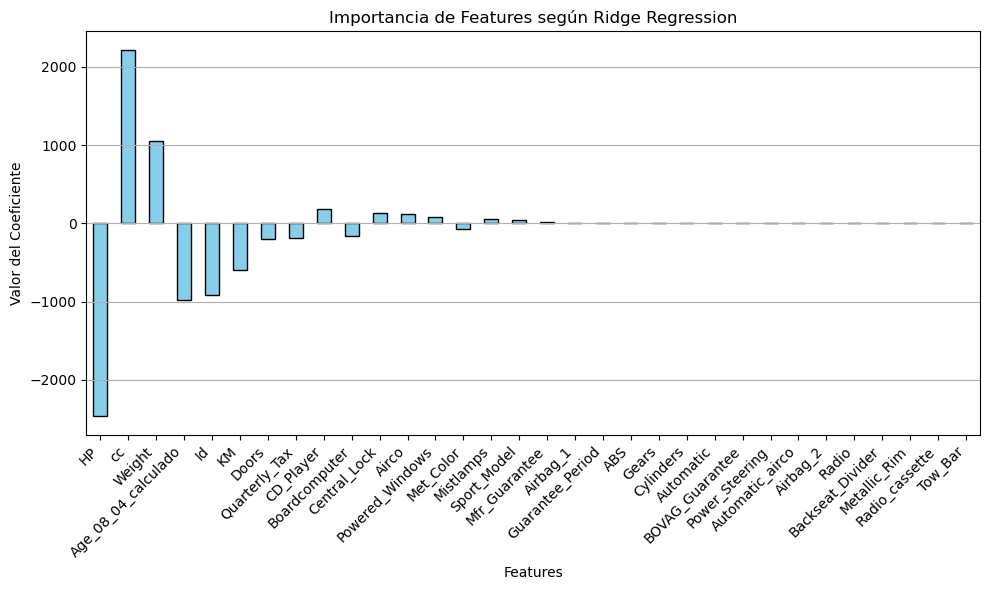

In [11]:
import matplotlib.pyplot as plt

# Ordenar coeficientes por valor absoluto
coef_sort = coeficientes.reindex(coeficientes.abs().sort_values(ascending=False).index)

# Gráfico
plt.figure(figsize=(10, 6))
coef_sort.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Importancia de Features según Ridge Regression")
plt.ylabel("Valor del Coeficiente")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


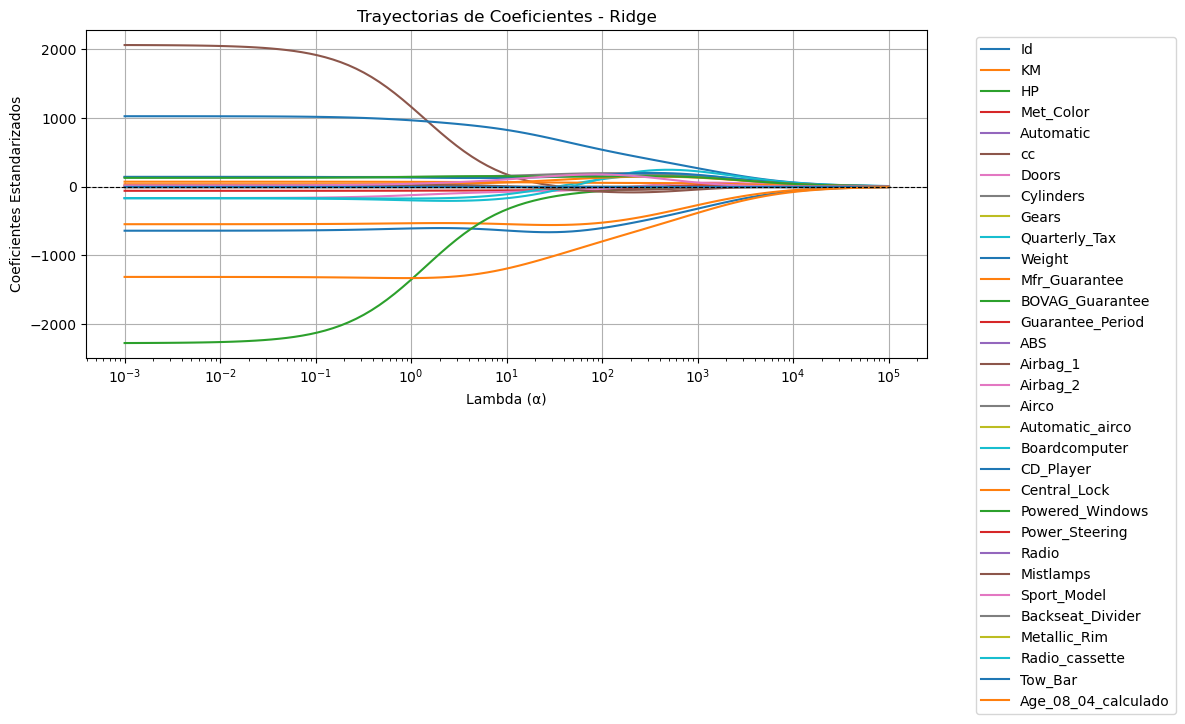

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge

# Asegurate de tener X (sin 'Price', 'Boardcomputer', 'cc') y y = df_rd["Price"]
features = X.columns  # Lista de nombres de features
alphas = np.logspace(-3, 5, 100)
coefs = []

# Entrenar Ridge para cada alpha y guardar coeficientes
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y)  # Usamos todos los datos escalados
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# 5. Graficar trayectorias de coeficientes
plt.figure(figsize=(12, 6))
for i in range(len(features)):
    plt.plot(alphas, coefs[:, i], label=features[i])

plt.xscale('log')
plt.xlabel("Lambda")
plt.ylabel("Coeficientes Estandarizados")
plt.title("Trayectorias de Coeficientes - Ridge")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
